In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn imports for non-Bayesian models and hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from joblib import parallel_backend

In [12]:
def drop_old_incomplete_rows(df, date_col, frac_threshold=0.5):
    """
    Drops rows where:
      1) The fraction of missing values in that row is >= frac_threshold
      2) The date in that row is strictly in the past (compared to 'today')

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame
    date_col : str
        Name of the date column in df
    frac_threshold : float
        Fraction of columns that must be missing to consider the row as 'incomplete'.
        E.g. frac_threshold=0.5 => row is incomplete if >= 50% columns are NaN.

    Returns
    -------
    pd.DataFrame
        The cleaned DataFrame
    """
    # Ensure the date column is of datetime type
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Current date (you could also fix a cutoff date if needed)
    now = pd.to_datetime("today")

    # Calculate fraction of missing values for each row
    frac_missing = df.isna().sum(axis=1) / df.shape[1]

    # Condition 1: fraction missing is >= threshold
    cond_incomplete = frac_missing >= frac_threshold
    # Condition 2: date is in the past
    cond_in_past = df[date_col] < now

    # Keep only rows that do NOT match (incomplete & in past)
    df_clean = df[~(cond_incomplete & cond_in_past)].copy()
    df_clean.reset_index(drop=True, inplace=True)
    return df_clean


def impute_missing_with_columnmean_up_until_that_date(df):
    """
    Impute missing numeric values with the mean computed from all rows up until (but not including) the current row.
    
    Parameters:
      df (pd.DataFrame): A DataFrame that is sorted by date in ascending order. It should contain a 'date' column.
      
    Returns:
      pd.DataFrame: A copy of df with missing values imputed for numeric columns.
    """
    df_imputed = df.copy()
    # Select numeric columns (excluding 'date' if it's not numeric)
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    
    for col in numeric_cols:
        # Compute the expanding mean for each column, then shift by 1 so that each row only uses past data
        cum_mean = df_imputed[col].expanding(min_periods=1).mean().shift(1)
        # Fill missing values in the column using the computed cumulative mean
        df_imputed[col] = df_imputed[col].fillna(cum_mean)
    
    return df_imputed
    


In [13]:

# =============================================================================
# 1. Load and Preprocess the Data (Time-Aware)
# =============================================================================ja m
def load_data(csv_path):
    """
    Load the soccer dataset from a CSV file.
    Assumes that:
      - The outcome variable is "match_result" encoded as 1 (Home win), 
        0 (Draw) and -1 (Away win).
      - There is a date column "date" that indicates when each match occurred.
    
    We:
      - Convert "date" to datetime and sort the DataFrame by date.
      - Create a binary variable "home_win" (1 if match_result==1, else 0).
      - Create a categorical outcome "match_result_cat" with values 0, 1, 2, where we map:
          -1 -> 0, 0 -> 1, 1 -> 2.
    """
    df = pd.read_csv(csv_path)
    
    # Convert the "date" column to datetime and sort the data by date.
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Create binary outcome (for models that might use it)
    df['home_win'] = (df['match_result'] == 1).astype(int)
    
    # Recode match_result into a categorical variable for multinomial models:
    mapping = {-1: 0, 0: 1, 1: 2}
    df['match_result_cat'] = df['match_result'].map(mapping).astype('category')

    return df

csv_path = "/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/final/PL_final_dataset.csv"
df = load_data(csv_path)
# Drop rows with many missing values and in the past
df = drop_old_incomplete_rows(df, date_col="date", frac_threshold=0.5)
# Restrict dataset to before today
df = df[df["date"] < pd.to_datetime("today")]
df = impute_missing_with_columnmean_up_until_that_date(df)
# Define feature columns (exclude outcome columns and other non-feature columns)
exclude_cols = ["match_result", "match_result_cat", "home_win", "date", "day", "score", "time", "Match_report", "notes", "venue", "referee", "game_id", "home_team", "away_team"]
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Convert all non-numeric columns in feature_cols into dummy variables
df_features = df[feature_cols]

# Split the data in a time-aware manner:
n = len(df_features)
train_end = int(0.9 * n)
df_features_train = df_features.iloc[:train_end].reset_index(drop=True)
df_features_test = df_features.iloc[train_end:].reset_index(drop=True)

# Use the "match_result_cat" column from the original df for the target
y_multi = df["match_result_cat"].cat.codes.values  # values in {0,1,2}
y_multi_train = y_multi[:train_end]
y_multi_test = y_multi[train_end:]

# Feature matrices:
X_train = df_features_train.values
X_test = df_features_test.values

print("Train set date range:", df.iloc[:train_end]["date"].min(), "to", df.iloc[:train_end]["date"].max())
print("Test set date range:", df.iloc[train_end:]["date"].min(), "to", df.iloc[train_end:]["date"].max())


Train set date range: 2018-08-18 00:00:00 to 2024-08-31 00:00:00
Test set date range: 2024-09-01 00:00:00 to 2025-02-27 00:00:00


Best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 20, 'n_estimators': 250}
Best CV accuracy: 0.5890710382513661

Tuned Random Forest: Accuracy = 0.566, Log Loss = 0.965

Confusion Matrix:
           Away win  Draw  Home win
Away win        55     0        31
Draw            22     0        39
Home win        14     0        83


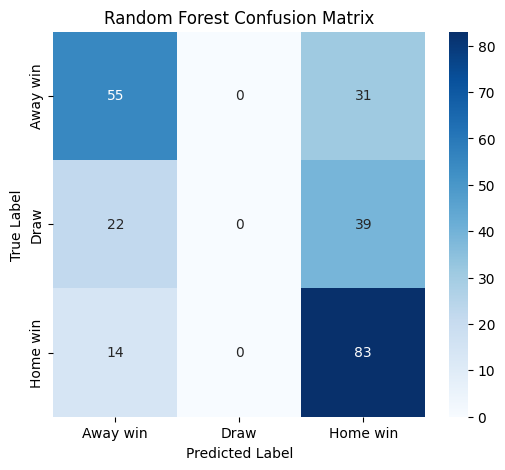

In [14]:
def tune_random_forest(X_train, y_train):
    """
    Tune hyperparameters for RandomForestClassifier using TimeSeriesSplit,
    preserving the temporal order in our soccer dataset.
    """
    param_grid = {
        'n_estimators': [50 , 75, 100, 250],
        'max_depth': [2, 5],
        'min_samples_split': [20],
        'min_samples_leaf': [8,9,10],
        'max_features': ['sqrt']
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    rf = RandomForestClassifier(random_state=42)
    
    # Use parallel_backend to parallelize grid search without verbose output.
    with parallel_backend('loky', n_jobs=-1):
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=tscv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=0,  # Set verbose to 0 to suppress detailed output
            pre_dispatch='2*n_jobs'
        )
        grid_search.fit(X_train, y_train)
    
    print("Best parameters found:", grid_search.best_params_)
    print("Best CV accuracy:", grid_search.best_score_)
    
    return grid_search.best_estimator_

# Tune Random Forest on training data:
best_rf = tune_random_forest(X_train, y_multi_train)

# Evaluate on test set:
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)
acc = accuracy_score(y_multi_test, y_pred)
ll = log_loss(y_multi_test, y_proba)
print("\nTuned Random Forest: Accuracy = {:.3f}, Log Loss = {:.3f}".format(acc, ll))

# Compute and display the confusion matrix:
cm = pd.DataFrame(
    confusion_matrix(y_multi_test, y_pred),
    index=["Away win", "Draw", "Home win"],
    columns=["Away win", "Draw", "Home win"]
)
print("\nConfusion Matrix:\n", cm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()



/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_98010/3158227447.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='week', y='correct', data=weekly_accuracy, palette='viridis')


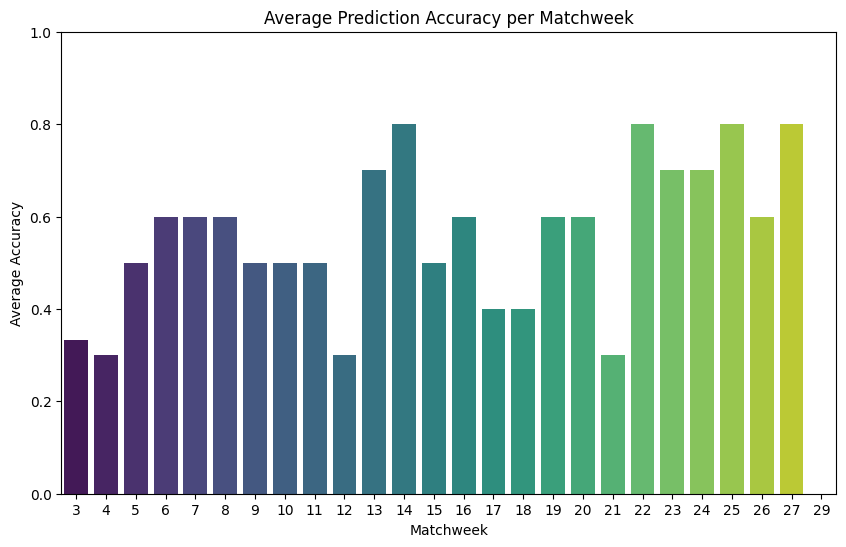

In [15]:
def plot_accuracy_by_matchweek(df_test, y_true, y_pred):
    """
    Compute the average prediction accuracy per matchweek and plot it as a barplot.
    
    Assumes:
      - df_test contains a column "matchweek" indicating the match week number.
      - y_true: true target values (e.g., from "match_result_cat").
      - y_pred: predicted target values.
    """
    # Create a copy of the test DataFrame and add a column indicating whether the prediction was correct.
    df_plot = df_test.copy()
    df_plot['correct'] = (y_true == y_pred).astype(int)
    
    # Group by matchweek and compute the mean accuracy.
    weekly_accuracy = df_plot.groupby('week')['correct'].mean().reset_index()
    
    # Plot the results in a barplot.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='week', y='correct', data=weekly_accuracy, palette='viridis')
    plt.xlabel("Matchweek")
    plt.ylabel("Average Accuracy")
    plt.title("Average Prediction Accuracy per Matchweek")
    plt.ylim(0, 1)
    plt.show()

# Evaluate the model on the test set.
y_pred = best_rf.predict(X_test)

# Plot the average accuracy by matchweek.
plot_accuracy_by_matchweek(df.iloc[train_end:].reset_index(drop=True), y_multi_test, y_pred)


Multinomial Logistic Regression: Accuracy = 0.602, Log Loss = 0.853


/Users/luisenriquekaiser/Documents/soccer_betting_forecast/soccer_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


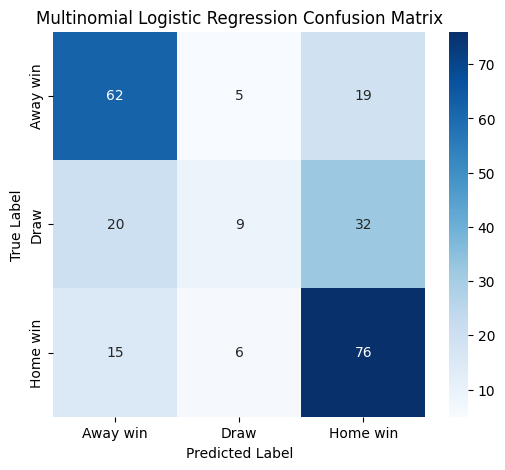

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define a pipeline that scales the data and fits a multinomial logistic regression model
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
)

# Fit the model on the training data
pipe.fit(X_train, y_multi_train)

# Predict on the test set
y_pred_logit = pipe.predict(X_test)
y_proba_logit = pipe.predict_proba(X_test)

# Evaluate the predictions
acc_logit = accuracy_score(y_multi_test, y_pred_logit)
ll_logit = log_loss(y_multi_test, y_proba_logit)
print(f"Multinomial Logistic Regression: Accuracy = {acc_logit:.3f}, Log Loss = {ll_logit:.3f}")

# Compute and display the confusion matrix
cm_logit = confusion_matrix(y_multi_test, y_pred_logit)
plt.figure(figsize=(6,5))
sns.heatmap(cm_logit, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Away win", "Draw", "Home win"],
            yticklabels=["Away win", "Draw", "Home win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multinomial Logistic Regression Confusion Matrix")
plt.show()


/var/folders/k1/n035yq891w95hzqpmlll09k80000gn/T/ipykernel_98010/2793043007.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='week', y='correct', data=weekly_accuracy, palette='viridis')


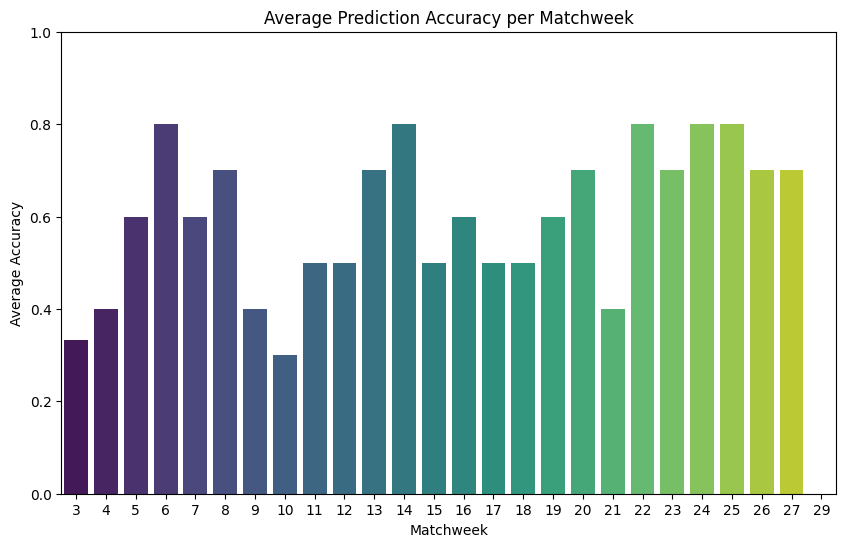

In [17]:
def plot_accuracy_by_matchweek(df_test, y_true, y_pred):
    """
    Compute the average prediction accuracy per matchweek and plot it as a barplot.
    
    Assumes:
      - df_test contains a column "matchweek" indicating the match week number.
      - y_true: true target values (e.g., from "match_result_cat").
      - y_pred: predicted target values.
    """
    # Create a copy of the test DataFrame and add a column indicating whether the prediction was correct.
    df_plot = df_test.copy()
    df_plot['correct'] = (y_true == y_pred).astype(int)
    
    # Group by matchweek and compute the mean accuracy.
    weekly_accuracy = df_plot.groupby('week')['correct'].mean().reset_index()
    
    # Plot the results in a barplot.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='week', y='correct', data=weekly_accuracy, palette='viridis')
    plt.xlabel("Matchweek")
    plt.ylabel("Average Accuracy")
    plt.title("Average Prediction Accuracy per Matchweek")
    plt.ylim(0, 1)
    plt.show()

# Evaluate the model on the test set.
y_pred = pipe.predict(X_test)

# Plot the average accuracy by matchweek.
plot_accuracy_by_matchweek(df.iloc[train_end:].reset_index(drop=True), y_multi_test, y_pred)

In [10]:
from sklearn.metrics import f1_score, classification_report

# For the tuned Random Forest model:
f1_rf = f1_score(y_multi_test, y_pred, average='weighted')
print("Random Forest Weighted F1 Score:", f1_rf)
print("\nClassification Report for Random Forest:")
print(classification_report(y_multi_test, y_pred, target_names=["Away win", "Draw", "Home win"]))

f1_log = f1_score(y_multi_test, y_pred_logit, average='weighted')
print("\nLogistic Regression Weighted F1 Score:", f1_log)
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_multi_test, y_pred_logit, target_names=["Away win", "Draw", "Home win"]))

Random Forest Weighted F1 Score: 0.4830095396869501

Classification Report for Random Forest:
              precision    recall  f1-score   support

    Away win       0.60      0.64      0.62        86
        Draw       0.00      0.00      0.00        61
    Home win       0.54      0.86      0.66        97

    accuracy                           0.57       244
   macro avg       0.38      0.50      0.43       244
weighted avg       0.43      0.57      0.48       244


Logistic Regression Weighted F1 Score: 0.5641401974209015

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Away win       0.64      0.72      0.68        86
        Draw       0.45      0.15      0.22        61
    Home win       0.60      0.78      0.68        97

    accuracy                           0.60       244
   macro avg       0.56      0.55      0.53       244
weighted avg       0.58      0.60      0.56       244



/Users/luisenriquekaiser/Documents/soccer_betting_forecast/soccer_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luisenriquekaiser/Documents/soccer_betting_forecast/soccer_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luisenriquekaiser/Documents/soccer_betting_forecast/soccer_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('/Users/luisenriquekaiser/Documents/soccer_betting_forecast/data/final/PL_final_dataset.csv')

# Ensure the date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Define function to assign season based on the month and year
def assign_season(date):
    year = date.year
    month = date.month
    if month >= 8:  # August to December
        return f"{year}-{year+1}"
    else:  # January to May (part of the previous season)
        return f"{year-1}-{year}"

# Apply the function to assign season
df['season'] = df['date'].apply(assign_season)

# Number each unique season
df['season_number'] = df['season'].astype('category').cat.codes + 1

# Output the partitioned dataframe
print(df.head())

   week  day       date   time       home_team  home_xg score  away_xg  \
0     1  Fri 2018-08-10  20:00  Manchester Utd      1.5   2–1      1.8   
1     1  Sat 2018-08-11  15:00     Bournemouth      2.2   2–0      1.4   
2     1  Sat 2018-08-11  15:00          Fulham      0.7   0–2      1.0   
3     1  Sat 2018-08-11  15:00    Huddersfield      0.3   0–3      1.9   
4     1  Sat 2018-08-11  12:30   Newcastle Utd      1.0   1–2      2.0   

        away_team  attendance  ... away_mean_Expected_npxG_last_3  \
0  Leicester City     74439.0  ...                            NaN   
1    Cardiff City     10353.0  ...                            NaN   
2  Crystal Palace     24821.0  ...                            NaN   
3         Chelsea     24121.0  ...                            NaN   
4       Tottenham     51749.0  ...                            NaN   

  home_mean_Expected_npxG/Sh_last_3 away_mean_Expected_npxG/Sh_last_3  \
0                               NaN                               N

In [ ]:
df